# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


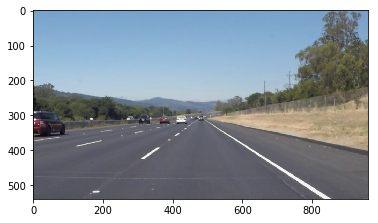

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [223]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    slope_dict = {}
    neg_slope_list = []
    pos_slope_list = []
    pos_slope_points = []
    neg_slope_points = []
    delta = 0.5
    
    for line in lines:
        #print("type = " + str(type(line)))
        #print("line = " + str(line))
        for x1,y1,x2,y2 in line:
            slope = float((y2-y1)/(x2-x1))
            slope = round(slope, 2)
            
            if slope < 0:
                neg_slope_list.append(slope)
                neg_slope_points.append((x1,y1))
                neg_slope_points.append((x2,y2))
            
            if slope > 0:
                pos_slope_list.append(slope)
                pos_slope_points.append((x1,y1))
                pos_slope_points.append((x2,y2))
            
            if not slope_dict:
                slope_dict[slope] = []
                slope_dict[slope].append((x1, y1, x2, y2))
            else:
                for key in list(slope_dict):
                    slope_upper = key + delta
                    slope_lower = key - delta
                    #print("Slope upper = " + str(slope_upper))
                    #print("Slope lower = " + str(slope_lower))
                    #print("Slope = " + str(slope))
                    if slope >= slope_lower and slope <= slope_upper:
                        slope_dict[key].append((x1, y1, x2, y2))
                        
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    mean_pos_slope = sum(pos_slope_list) / float(len(pos_slope_list))
    mean_neg_slope = sum(neg_slope_list) / float(len(neg_slope_list))
    
    print("mean postive slope =" + str(mean_pos_slope))
    print("mean negative slope =" + str(mean_neg_slope))
    print("Negative slope points =" + str(neg_slope_points))
    print("Positive slope points =" + str(pos_slope_points))
    
   
    #print("Slope Dictionary = " + str(slope_dict))
    print("Slope Dictionary keys = " + str(slope_dict.keys()))
    
    consolidated_slopes = {}
    
    
    
    for slope in slope_dict.keys():
        #print("slope = " + str(slope))
        if len(slope_dict[slope]) > 4:
            x0 = [x[0] for x in slope_dict[slope]]
            x2 = [x[2] for x in slope_dict[slope]]
            
            x_list = x0 + x2
            
            y1 = [y[1] for y in slope_dict[slope]]
            y3 = [y[3] for y in slope_dict[slope]]
            
            y_list = y1 + y3
                    
            z = np.polyfit(x_list, y_list, 1)
            
            x_min = int(min(x_list))
            y_min = int(x_min * z[0] + z[1])
            
            x_max = int(max(x_list))
            #print("z[0] " + str(z[0]))
            #print("z[1] " + str(z[1]))
            y_max = int(x_max * z[0] + z[1])
            
            #print("x_min = " + str(x_min) + "x_max = " + str(x_max))
            #print("y_min = " + str(y_min) + "y_max = " + str(x_max))
            #cv2.line(img, (x_min, y_min), (x_max, y_max), color, thickness)
            
     
    #for slope in slope_dict.keys():
    #    if len(slope_dict[slope]) == 4:
    #        slope_tup = slope_dict[slope]
                 
    #        cv2.line(img, (slope_tup[0], slope_tup[1]), (slope_tup[2], slope_tup[3]), color, thickness)        
           
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

mean postive slope =0.48032258064516137
mean negative slope =-0.865
Negative slope points =[(328, 424), (339, 417), (482, 316), (489, 315), (326, 436), (333, 429), (282, 471), (300, 455), (386, 389), (397, 380), (399, 379), (406, 372), (304, 443), (317, 432), (348, 409), (356, 404), (262, 475), (268, 469), (447, 338), (456, 329), (354, 414), (364, 404), (435, 352), (463, 329), (464, 324), (470, 318), (283, 459), (289, 453), (274, 466), (281, 459), (356, 403), (362, 400), (426, 359), (432, 353), (366, 397), (374, 390), (417, 359), (423, 355), (211, 526), (239, 504), (408, 367), (414, 361), (175, 538), (188, 530), (648, 407), (654, 406), (224, 503), (236, 493), (397, 375), (402, 370), (452, 334), (462, 324), (408, 372), (414, 366), (257, 491), (267, 481), (247, 485), (259, 477), (361, 408), (369, 400), (335, 429), (342, 422), (234, 496), (240, 490), (195, 539), (199, 534), (413, 368), (418, 363), (339, 426), (351, 415), (301, 455), (315, 443), (401, 372), (406, 367), (262, 487), (268, 48

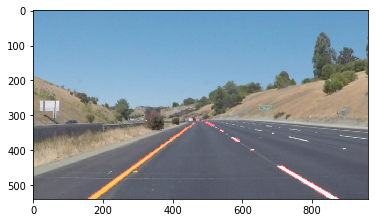

In [224]:
# Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

for img_file in os.listdir("test_images/"):
    img =  mpimg.imread("test_images/"+img_file)
    imshape = img.shape
    gray_img = grayscale(img)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray_img, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    vertices = np.array([[(150,imshape[0]),(470, 305), (470, 305), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments

    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw the lines on the edge image
    lines_edges = weighted_img(img, line_image, 0.8, 1, 0)
    plt.imshow(lines_edges)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [195]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [213]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    imshape = image.shape
    gray_img = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray_img, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    vertices = np.array([[(150,imshape[0]),(470, 305), (470, 305), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments

    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    result = weighted_img(image, line_image, 0.8, 1, 0) 
    
    return result

Let's try the one with the solid white lane on the right first ...

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [214]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,4)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

mean postive slope =0.5559999999999998
mean negative slope =-0.8214285714285715
Slope Dictionary keys = dict_keys([-0.65])
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  3%|▎         | 3/101 [00:00<00:03, 26.39it/s]

mean postive slope =0.5559999999999998
mean negative slope =-0.8214285714285715
Slope Dictionary keys = dict_keys([-0.65])
mean postive slope =0.5271428571428574
mean negative slope =-0.7380952380952381
Slope Dictionary keys = dict_keys([0.58])
mean postive slope =0.5945454545454546
mean negative slope =-0.8205
Slope Dictionary keys = dict_keys([0.6])
mean postive slope =0.5776744186046514
mean negative slope =-0.7605882352941177
Slope Dictionary keys = dict_keys([0.64])
mean postive slope =0.5696969696969696
mean negative slope =-0.8158823529411764
Slope Dictionary keys = dict_keys([0.61])


  9%|▉         | 9/101 [00:00<00:03, 26.38it/s]

mean postive slope =0.5900000000000001
mean negative slope =-0.7545454545454546
Slope Dictionary keys = dict_keys([0.55])
mean postive slope =0.5335294117647059
mean negative slope =-0.7307692307692307
Slope Dictionary keys = dict_keys([0.57])
mean postive slope =0.522121212121212
mean negative slope =-0.7853333333333334
Slope Dictionary keys = dict_keys([0.6])
mean postive slope =0.49818181818181795
mean negative slope =-0.66
Slope Dictionary keys = dict_keys([-0.71])
mean postive slope =0.5112765957446808
mean negative slope =-0.658125
Slope Dictionary keys = dict_keys([0.6])
mean postive slope =0.5292982456140352
mean negative slope =-0.6876923076923076
Slope Dictionary keys = dict_keys([0.62])
mean postive slope =0.5460526315789475
mean negative slope =-0.8072727272727274
Slope Dictionary keys = dict_keys([0.65])


 17%|█▋        | 17/101 [00:00<00:02, 30.28it/s]

mean postive slope =0.5451282051282053
mean negative slope =-0.9646153846153847
Slope Dictionary keys = dict_keys([0.59])
mean postive slope =0.6056000000000001
mean negative slope =-0.7488235294117649
Slope Dictionary keys = dict_keys([0.56])
mean postive slope =0.5392307692307695
mean negative slope =-0.7591666666666667
Slope Dictionary keys = dict_keys([0.6])
mean postive slope =0.53225
mean negative slope =-0.6666666666666666
Slope Dictionary keys = dict_keys([-0.7])
mean postive slope =0.5546153846153847
mean negative slope =-0.6733333333333332
Slope Dictionary keys = dict_keys([1.0])
mean postive slope =0.5404255319148936
mean negative slope =-0.6425000000000001
Slope Dictionary keys = dict_keys([0.67])
mean postive slope =0.6079411764705883
mean negative slope =-0.711111111111111
Slope Dictionary keys = dict_keys([-0.5])
mean postive slope =0.6041304347826087
mean negative slope =-0.71
Slope Dictionary keys = dict_keys([0.61])


 24%|██▍       | 24/101 [00:00<00:02, 31.21it/s]

mean postive slope =0.5895744680851065
mean negative slope =-0.7553846153846154
Slope Dictionary keys = dict_keys([0.64])
mean postive slope =0.5317777777777776
mean negative slope =-0.7999999999999999
Slope Dictionary keys = dict_keys([0.65])
mean postive slope =0.5673584905660376
mean negative slope =-0.7221052631578947
Slope Dictionary keys = dict_keys([0.6])
mean postive slope =0.5430357142857143
mean negative slope =-0.7840000000000001
Slope Dictionary keys = dict_keys([-0.69])
mean postive slope =0.5925
mean negative slope =-0.7219047619047618
Slope Dictionary keys = dict_keys([0.63])
mean postive slope =0.5785365853658538
mean negative slope =-0.7735000000000001
Slope Dictionary keys = dict_keys([0.65])
mean postive slope =0.5705555555555556
mean negative slope =-0.7895238095238096
Slope Dictionary keys = dict_keys([0.6])


 32%|███▏      | 32/101 [00:01<00:02, 32.23it/s]

mean postive slope =0.6046428571428573
mean negative slope =-0.7706666666666666
Slope Dictionary keys = dict_keys([0.65])
mean postive slope =0.5351111111111112
mean negative slope =-0.7492307692307691
Slope Dictionary keys = dict_keys([0.4])
mean postive slope =0.5377083333333332
mean negative slope =-0.7518181818181818
Slope Dictionary keys = dict_keys([0.63])
mean postive slope =0.6075510204081632
mean negative slope =-0.8076923076923077
Slope Dictionary keys = dict_keys([0.64])
mean postive slope =0.5710256410256411
mean negative slope =-0.776
Slope Dictionary keys = dict_keys([0.67])
mean postive slope =0.6088888888888887
mean negative slope =-0.7753333333333334
Slope Dictionary keys = dict_keys([0.4])
mean postive slope =0.596
mean negative slope =-0.7293750000000001
Slope Dictionary keys = dict_keys([0.65])


 36%|███▌      | 36/101 [00:01<00:01, 32.76it/s]

mean postive slope =0.5652380952380952
mean negative slope =-0.8014285714285714
Slope Dictionary keys = dict_keys([0.73])
mean postive slope =0.592820512820513
mean negative slope =-0.6978260869565218
Slope Dictionary keys = dict_keys([0.63])
mean postive slope =0.5385294117647059
mean negative slope =-0.893478260869565
Slope Dictionary keys = dict_keys([0.61])
mean postive slope =0.5617948717948718
mean negative slope =-0.7781250000000001
Slope Dictionary keys = dict_keys([-0.75])
mean postive slope =0.5265957446808511
mean negative slope =-0.8089999999999999
Slope Dictionary keys = dict_keys([0.63])


 40%|███▉      | 40/101 [00:01<00:01, 31.74it/s]

mean postive slope =0.6733333333333333
mean negative slope =-0.7615384615384616
Slope Dictionary keys = dict_keys([0.62])
mean postive slope =0.5569565217391304

 44%|████▎     | 44/101 [00:01<00:01, 28.54it/s]


mean negative slope =-0.8509090909090911
Slope Dictionary keys = dict_keys([0.65])
mean postive slope =0.596969696969697
mean negative slope =-0.7857142857142857
Slope Dictionary keys = dict_keys([0.67])
mean postive slope =0.6427027027027027
mean negative slope =-0.786923076923077
Slope Dictionary keys = dict_keys([-0.86])
mean postive slope =0.621304347826087
mean negative slope =-0.788
Slope Dictionary keys = dict_keys([0.71])
mean postive slope =0.6324
mean negative slope =-0.6958333333333332
Slope Dictionary keys = dict_keys([0.4])
mean postive slope =0.565263157894737
mean negative slope =-0.8500000000000001
Slope Dictionary keys = dict_keys([0.64])
mean postive slope =0.6503703703703705
mean negative slope =-0.6666666666666666
Slope Dictionary keys = dict_keys([-0.69])


 50%|████▉     | 50/101 [00:01<00:02, 17.35it/s]

mean postive slope =0.5790000000000001
mean negative slope =-0.735
Slope Dictionary keys = dict_keys([0.5])
mean postive slope =0.6278260869565218
mean negative slope =-0.67
Slope Dictionary keys = dict_keys([0.67])
mean postive slope =0.6337037037037038
mean negative slope =-0.8193333333333334
Slope Dictionary keys = dict_keys([0.62])


 52%|█████▏    | 53/101 [00:02<00:02, 17.94it/s]

mean postive slope =0.550952380952381
mean negative slope =-0.7569230769230769
Slope Dictionary keys = dict_keys([0.62])
mean postive slope =0.6456410256410259
mean negative slope =-0.7277777777777779
Slope Dictionary keys = dict_keys([0.75])
mean postive slope =0.611935483870968
mean negative slope =-0.722857142857143
Slope Dictionary keys = dict_keys([0.63])
mean postive slope =0.5768571428571428
mean negative slope =-0.7888888888888889
Slope Dictionary keys = dict_keys([-0.44])


 55%|█████▌    | 56/101 [00:02<00:02, 16.95it/s]

mean postive slope =0.6086666666666668
mean negative slope =-0.7324999999999999
Slope Dictionary keys = dict_keys([0.56])
mean postive slope =0.5871153846153846
mean negative slope =-0.708
Slope Dictionary keys = dict_keys([0.56])
mean postive slope =0.5563636363636365
mean negative slope =-0.687142857142857
Slope Dictionary keys = dict_keys([0.59])
mean postive slope =0.5745454545454547
mean negative slope =-1.1008333333333333
Slope Dictionary keys = dict_keys([0.5])


 59%|█████▉    | 60/101 [00:02<00:03, 12.59it/s]

mean postive slope =0.5579545454545456
mean negative slope =-0.7183333333333334
Slope Dictionary keys = dict_keys([0.65])
mean postive slope =0.5435897435897434
mean negative slope =-0.6138461538461539
Slope Dictionary keys = dict_keys([0.62])


 61%|██████▏   | 62/101 [00:02<00:03, 11.55it/s]

mean postive slope =0.5630612244897959
mean negative slope =-0.678
Slope Dictionary keys = dict_keys([0.62])
mean postive slope =0.5856097560975609
mean negative slope =-0.7444444444444445
Slope Dictionary keys = dict_keys([0.64])
mean postive slope =0.5839583333333332
mean negative slope =-0.7809090909090909
Slope Dictionary keys = dict_keys([0.4])


 65%|██████▌   | 66/101 [00:03<00:02, 12.14it/s]

mean postive slope =0.5726415094339623
mean negative slope =-0.6842857142857143
Slope Dictionary keys = dict_keys([0.8])
mean postive slope =0.6005769230769231
mean negative slope =-0.684
Slope Dictionary keys = dict_keys([0.61])
mean postive slope =0.5722222222222223
mean negative slope =-0.6788888888888889
Slope Dictionary keys = dict_keys([0.59])


 67%|██████▋   | 68/101 [00:03<00:02, 13.20it/s]

mean postive slope =0.6100000000000001
mean negative slope =-0.7175
Slope Dictionary keys = dict_keys([0.67])
mean postive slope =0.6537037037037038
mean negative slope =-0.7428571428571429
Slope Dictionary keys = dict_keys([0.67])
mean postive slope =0.6096666666666667
mean negative slope =-0.7333333333333334
Slope Dictionary keys = dict_keys([0.67])
mean postive slope =0.5604545454545454
mean negative slope =-0.69125
Slope Dictionary keys = dict_keys([0.57])


 73%|███████▎  | 74/101 [00:03<00:01, 15.08it/s]

mean postive slope =0.5482926829268293
mean negative slope =-0.7242857142857142
Slope Dictionary keys = dict_keys([0.78])
mean postive slope =0.5929032258064517
mean negative slope =-0.7622222222222222
Slope Dictionary keys = dict_keys([0.57])
mean postive slope =0.6131818181818182
mean negative slope =-0.7374999999999999
Slope Dictionary keys = dict_keys([0.65])
mean postive slope =0.5880434782608698
mean negative slope =-0.5788888888888889
Slope Dictionary keys = dict_keys([0.64])


 75%|███████▌  | 76/101 [00:03<00:01, 15.36it/s]

mean postive slope =0.5860526315789475
mean negative slope =-0.6755555555555555
Slope Dictionary keys = dict_keys([0.6])
mean postive slope =0.5269491525423727
mean negative slope =-0.6499999999999999
Slope Dictionary keys = dict_keys([0.56])
mean postive slope =0.5988372093023254
mean negative slope =-0.6414285714285715
Slope Dictionary keys = dict_keys([0.7])
mean postive slope =0.612962962962963
mean negative slope =-0.61625
Slope Dictionary keys = dict_keys([0.68])


 79%|███████▉  | 80/101 [00:04<00:01, 13.58it/s]

mean postive slope =0.5368965517241379
mean negative slope =-0.72
Slope Dictionary keys = dict_keys([0.61])
mean postive slope =0.5707547169811319
mean negative slope =-0.734
Slope Dictionary keys = dict_keys([0.61])
mean postive slope =0.6323255813953488
mean negative slope =-0.72
Slope Dictionary keys = dict_keys([0.67])
mean postive slope =0.6815
mean negative slope =-0.6957142857142857
Slope Dictionary keys = dict_keys([0.64])


 83%|████████▎ | 84/101 [00:04<00:01, 12.62it/s]

mean postive slope =0.6376315789473687
mean negative slope =-0.698
Slope Dictionary keys = dict_keys([0.71])
mean postive slope =0.564909090909091
mean negative slope =-0.6933333333333334
Slope Dictionary keys = dict_keys([0.64])


 85%|████████▌ | 86/101 [00:04<00:01, 13.54it/s]

mean postive slope =0.5562068965517241
mean negative slope =-0.5455555555555555
Slope Dictionary keys = dict_keys([0.56])
mean postive slope =0.6279069767441862
mean negative slope =-0.7516666666666666
Slope Dictionary keys = dict_keys([0.5])
mean postive slope =0.6112903225806453
mean negative slope =-0.6314285714285715
Slope Dictionary keys = dict_keys([0.72])


 89%|████████▉ | 90/101 [00:04<00:00, 12.55it/s]

mean postive slope =0.6319047619047617
mean negative slope =-0.628
Slope Dictionary keys = dict_keys([0.67])
mean postive slope =0.6869565217391307
mean negative slope =-0.6322222222222222
Slope Dictionary keys = dict_keys([0.17])
mean postive slope =0.6151162790697676
mean negative slope =-0.7783333333333333
Slope Dictionary keys = dict_keys([-0.71])
mean postive slope =0.6243243243243245

 91%|█████████ | 92/101 [00:05<00:00, 11.86it/s]


mean negative slope =-0.6211111111111111
Slope Dictionary keys = dict_keys([0.72])
mean postive slope =0.6460000000000002
mean negative slope =-0.6075
Slope Dictionary keys = dict_keys([0.71])
mean postive slope =0.5985106382978723
mean negative slope =-0.664
Slope Dictionary keys = dict_keys([0.6])
mean postive slope =0.6631250000000001
mean negative slope =-0.7466666666666666
Slope Dictionary keys = dict_keys([0.67])


 96%|█████████▌| 97/101 [00:05<00:00, 12.21it/s]

mean postive slope =0.6583333333333331
mean negative slope =-0.6883333333333334
Slope Dictionary keys = dict_keys([0.6])
mean postive slope =0.6752631578947369
mean negative slope =-0.72
Slope Dictionary keys = dict_keys([0.5])
mean postive slope =0.5665999999999999
mean negative slope =-0.7414285714285713
Slope Dictionary keys = dict_keys([0.62])
mean postive slope =0.5688235294117648
mean negative slope =-0.65
Slope Dictionary keys = dict_keys([0.4])


 99%|█████████▉| 100/101 [00:05<00:00, 17.28it/s]

mean postive slope =0.565
mean negative slope =-0.7012499999999999
Slope Dictionary keys = dict_keys([0.68])
mean postive slope =0.665945945945946
mean negative slope =-0.6180000000000001
Slope Dictionary keys = dict_keys([0.73])


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1.53 s, sys: 305 ms, total: 1.83 s
Wall time: 7.6 s


In [155]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [1]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

NameError: name 'VideoFileClip' is not defined

In [77]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [215]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

mean postive slope =0.5547619047619046
mean negative slope =-0.5946078431372548
Slope Dictionary keys = dict_keys([-5.0])
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 2/251 [00:00<00:15, 16.57it/s]

mean postive slope =0.5547619047619046
mean negative slope =-0.5946078431372548
Slope Dictionary keys = dict_keys([-5.0])
mean postive slope =0.47605263157894734
mean negative slope =-0.5926415094339621
Slope Dictionary keys = dict_keys([0.17])
mean postive slope =0.38374999999999987
mean negative slope =-0.5471951219512194
Slope Dictionary keys = dict_keys([0.0])


  2%|▏         | 6/251 [00:00<00:14, 16.34it/s]

mean postive slope =0.30111111111111105
mean negative slope =-0.5118999999999998
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.3781818181818182
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.77])
mean postive slope =0.354
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.62])
mean postive slope =0.3849999999999999
mean negative slope =-0.6139325842696628
Slope Dictionary keys = dict_keys([-0.28])


  4%|▍         | 10/251 [00:00<00:13, 17.31it/s]

mean postive slope =0.4581818181818182
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.5])
mean postive slope =0.5811999999999999
mean negative slope =-0.5083999999999999
Slope Dictionary keys = dict_keys([0.5])
mean postive slope =0.3851428571428571
mean negative slope =-0.6398717948717951
Slope Dictionary keys = dict_keys([0.5])


  6%|▌         | 14/251 [00:00<00:13, 18.16it/s]

mean postive slope =0.4216666666666667
mean negative slope =-0.5827173913043479
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.4843589743589743
mean negative slope =-0.5069090909090909
Slope Dictionary keys = dict_keys([-0.08])
mean postive slope =0.5859374999999999
mean negative slope =-0.5447252747252747
Slope Dictionary keys = dict_keys([-0.73])
mean postive slope =0.4466666666666666
mean negative slope =-0.794622641509434
Slope Dictionary keys = dict_keys([-0.61])


  6%|▋         | 16/251 [00:00<00:13, 17.69it/s]

mean postive slope =0.43105263157894735
mean negative slope =-0.4958024691358026
Slope Dictionary keys = dict_keys([-0.38])
mean postive slope =0.4141176470588235
mean negative slope =-0.5356944444444441
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.36099999999999993
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.11])


  8%|▊         | 19/251 [00:01<00:12, 18.13it/s]

mean postive slope =0.4596296296296296
mean negative slope =-0.48478723404255314
Slope Dictionary keys = dict_keys([0.0])


  8%|▊         | 21/251 [00:01<00:13, 17.21it/s]

mean postive slope =0.42040000000000005
mean negative slope =-0.5009677419354839
Slope Dictionary keys = dict_keys([-1.0])
mean postive slope =inf
mean negative slope =-0.548051948051948
Slope Dictionary keys = dict_keys([-0.06])
mean postive slope =0.5947999999999999
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


  9%|▉         | 23/251 [00:01<00:12, 17.66it/s]

mean postive slope =0.5146153846153846
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 10%|▉         | 25/251 [00:01<00:12, 17.86it/s]

mean postive slope =0.5895744680851063
mean negative slope =-0.532
Slope Dictionary keys = dict_keys([0.08])
mean postive slope =0.6737500000000001
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.54])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.12])
mean postive slope =0.6742857142857143
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.9])


 11%|█         | 27/251 [00:01<00:13, 16.64it/s]

mean postive slope =0.9323076923076924
mean negative slope =-0.7428735632183904
Slope Dictionary keys = dict_keys([0.12])
mean postive slope =0.5187999999999999
mean negative slope =-0.5526829268292681
Slope Dictionary keys = dict_keys([-0.76])


 12%|█▏        | 29/251 [00:01<00:15, 14.55it/s]

mean postive slope =0.4125925925925926
mean negative slope =-0.5309210526315788
Slope Dictionary keys = dict_keys([-1.0])


 13%|█▎        | 33/251 [00:01<00:13, 16.32it/s]

mean postive slope =0.4580000000000001
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-1.0])
mean postive slope =0.6017241379310344
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.33])
mean postive slope =0.5199999999999999
mean negative slope =-0.520618556701031
Slope Dictionary keys = dict_keys([-0.8])
mean postive slope =0.4773684210526316
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.5])


 15%|█▍        | 37/251 [00:02<00:12, 16.53it/s]

mean postive slope =0.5663043478260871
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.61])
mean postive slope =0.5488524590163935
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])
mean postive slope =0.5337500000000001
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.45272727272727264
mean negative slope =-0.5265789473684211
Slope Dictionary keys = dict_keys([-0.23])


 16%|█▋        | 41/251 [00:02<00:12, 17.29it/s]

mean postive slope =0.5054285714285713
mean negative slope =-0.4061904761904761
Slope Dictionary keys = dict_keys([-0.57])
mean postive slope =0.7742857142857142
mean negative slope =-0.5497826086956522
Slope Dictionary keys = dict_keys([-0.75])
mean postive slope =0.8017857142857142
mean negative slope =-0.5156410256410258
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.8324390243902441
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.66])


 17%|█▋        | 43/251 [00:02<00:13, 15.97it/s]

mean postive slope =0.5367241379310344
mean negative slope =-0.48079999999999984
Slope Dictionary keys = dict_keys([-0.24])
mean postive slope =0.7859523809523811
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 18%|█▊        | 45/251 [00:02<00:15, 13.71it/s]

mean postive slope =0.8096875
mean negative slope =-0.7367796610169491
Slope Dictionary keys = dict_keys([-0.53])
mean postive slope =0.47859999999999997
mean negative slope =-0.579036144578313
Slope Dictionary keys = dict_keys([-0.67])
mean postive slope =0.7261764705882352
mean negative slope =-0.4917721518987339
Slope Dictionary keys = dict_keys([-0.67])


 19%|█▊        | 47/251 [00:03<00:23,  8.56it/s]

mean postive slope =0.539322033898305
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.54])
mean postive slope =0.5960000000000001
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.6])


 20%|██        | 51/251 [00:03<00:26,  7.41it/s]

mean postive slope =0.51
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.38])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.54])


 21%|██        | 52/251 [00:03<00:25,  7.87it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.58])
mean postive slope =0.49868421052631584
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.65])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 22%|██▏       | 55/251 [00:04<00:27,  7.07it/s]

mean postive slope =inf
mean negative slope =-0.6195312499999999
Slope Dictionary keys = dict_keys([-0.2])
mean postive slope =0.7690243902439025
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 23%|██▎       | 57/251 [00:04<00:25,  7.65it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.29])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 24%|██▍       | 60/251 [00:05<00:28,  6.68it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.88])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.75])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 25%|██▍       | 62/251 [00:05<00:27,  6.86it/s]

mean postive slope =inf
mean negative slope =-0.6276543209876545
Slope Dictionary keys = dict_keys([-1.0])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 25%|██▌       | 64/251 [00:05<00:31,  5.93it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-3.33])
mean postive slope =inf
mean negative slope =-0.6219999999999999
Slope Dictionary keys = dict_keys([-0.73])


 26%|██▋       | 66/251 [00:06<00:30,  6.12it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.69])


 27%|██▋       | 67/251 [00:06<00:29,  6.20it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.75])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.65])


 28%|██▊       | 70/251 [00:06<00:25,  7.04it/s]

mean postive slope =inf
mean negative slope =-0.5839743589743589
Slope Dictionary keys = dict_keys([-0.72])
mean postive slope =1.0777941176470591
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.57])


 29%|██▉       | 73/251 [00:06<00:22,  7.99it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-8.0])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.22])


 30%|██▉       | 75/251 [00:07<00:29,  5.96it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 31%|███       | 77/251 [00:07<00:28,  6.13it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 31%|███▏      | 79/251 [00:08<00:28,  6.10it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.17])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 32%|███▏      | 81/251 [00:08<00:26,  6.35it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.78])
mean postive slope =0.3848648648648649
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.75])


 33%|███▎      | 84/251 [00:08<00:24,  6.76it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.71])


 34%|███▍      | 85/251 [00:09<00:23,  7.15it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.9110344827586208
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.11])


 35%|███▍      | 87/251 [00:09<00:26,  6.28it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.29])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 35%|███▌      | 89/251 [00:09<00:26,  6.16it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-1.0])
mean postive slope =0.43866666666666665
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.11])


 36%|███▋      | 91/251 [00:10<00:25,  6.20it/s]

mean postive slope =0.37374999999999997
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-1.4])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 37%|███▋      | 93/251 [00:10<00:21,  7.21it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.6331707317073166
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 38%|███▊      | 95/251 [00:10<00:25,  6.21it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =inf
mean negative slope =-0.4859854014598544
Slope Dictionary keys = dict_keys([0.2])


 39%|███▊      | 97/251 [00:10<00:23,  6.63it/s]

mean postive slope =0.3445714285714285
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.25])
mean postive slope =0.3079310344827586
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 39%|███▉      | 99/251 [00:11<00:20,  7.32it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.19])
mean postive slope =0.32000000000000006
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 40%|████      | 101/251 [00:11<00:17,  8.39it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.62])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.12])


 41%|████▏     | 104/251 [00:11<00:22,  6.50it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.463103448275862
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.36])


 42%|████▏     | 106/251 [00:12<00:19,  7.29it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.69])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.396046511627907
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 43%|████▎     | 108/251 [00:12<00:27,  5.20it/s]

mean postive slope =0.54015873015873
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 44%|████▍     | 110/251 [00:12<00:24,  5.84it/s]

mean postive slope =0.4744444444444443
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.48622950819672117
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 44%|████▍     | 111/251 [00:12<00:24,  5.74it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])
mean postive slope =inf

 45%|████▍     | 112/251 [00:13<00:24,  5.72it/s]


mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.5])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.33])
mean postive slope =0.6658974358974359
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 46%|████▌     | 115/251 [00:13<00:22,  5.95it/s]

mean postive slope =0.8950000000000001
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.05])
mean postive slope =0.6927272727272727
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.14])


 47%|████▋     | 118/251 [00:14<00:20,  6.38it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.38])
mean postive slope =0.4199999999999999
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 47%|████▋     | 119/251 [00:14<00:21,  6.15it/s]

mean postive slope =0.8117647058823528
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 48%|████▊     | 120/251 [00:14<00:19,  6.83it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.07])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.32])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.1])


 49%|████▉     | 123/251 [00:14<00:17,  7.42it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.45])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 50%|████▉     | 125/251 [00:14<00:15,  7.98it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.2])


 51%|█████     | 127/251 [00:15<00:20,  5.96it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-3.0])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 51%|█████     | 128/251 [00:15<00:19,  6.26it/s]

mean postive slope =1.1083870967741936
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.2])


 52%|█████▏    | 130/251 [00:15<00:18,  6.48it/s]

mean postive slope =0.339
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-2.5])


 53%|█████▎    | 133/251 [00:16<00:19,  6.01it/s]

mean postive slope =0.6917142857142856
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.4344186046511627
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.4])


 53%|█████▎    | 134/251 [00:16<00:19,  5.95it/s]

mean postive slope =0.516734693877551
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.33352941176470585
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 54%|█████▍    | 136/251 [00:17<00:22,  5.09it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.2])


 55%|█████▍    | 138/251 [00:17<00:17,  6.48it/s]

mean postive slope =0.40933333333333327
mean negative slope =-0.4874418604651161
Slope Dictionary keys = dict_keys([-1.25])
mean postive slope =0.3878260869565217
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.5486206896551724
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.67])


 56%|█████▌    | 140/251 [00:17<00:20,  5.53it/s]

mean postive slope =0.3467857142857143
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.2799999999999999
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.53])


 57%|█████▋    | 142/251 [00:17<00:19,  5.65it/s]

mean postive slope =0.27843749999999995
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 57%|█████▋    | 143/251 [00:18<00:17,  6.03it/s]

mean postive slope =0.3174074074074074
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.3075925925925926
mean negative slope =-0.6213043478260872
Slope Dictionary keys = dict_keys([0.0])


 58%|█████▊    | 146/251 [00:18<00:15,  6.99it/s]

mean postive slope =0.4236363636363636
mean negative slope =-0.29138888888888886
Slope Dictionary keys = dict_keys([-0.2])
mean postive slope =0.30923076923076914
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 59%|█████▊    | 147/251 [00:18<00:16,  6.38it/s]

mean postive slope =0.26698412698412693
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.21166666666666667
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.17])


 59%|█████▉    | 148/251 [00:18<00:15,  6.80it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.3])
mean postive slope =0.3170588235294117
mean negative slope =-0.3638317757009345
Slope Dictionary keys = dict_keys([-0.57])


 60%|██████    | 151/251 [00:19<00:14,  7.06it/s]

mean postive slope =0.44333333333333336
mean negative slope =-0.4987878787878789
Slope Dictionary keys = dict_keys([0.86])
mean postive slope =0.3917391304347827
mean negative slope =-0.4697938144329896
Slope Dictionary keys = dict_keys([-0.2])


 61%|██████    | 152/251 [00:19<00:13,  7.29it/s]

mean postive slope =0.35482758620689653
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.6])
mean postive slope =0.37923076923076926
mean negative slope =-0.451078431372549
Slope Dictionary keys = dict_keys([0.0])


 62%|██████▏   | 155/251 [00:19<00:13,  7.08it/s]

mean postive slope =0.4027906976744186
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.3913333333333334
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 63%|██████▎   | 158/251 [00:20<00:12,  7.49it/s]

mean postive slope =0.3664
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.44])
mean postive slope =0.7693333333333333
mean negative slope =-0.4121782178217822
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.4473333333333333
mean negative slope =-0.45450549450549466
Slope Dictionary keys = dict_keys([-0.33])


 64%|██████▎   | 160/251 [00:20<00:14,  6.25it/s]

mean postive slope =0.4357894736842105
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 64%|██████▍   | 161/251 [00:20<00:15,  5.86it/s]

mean postive slope =0.3830434782608695
mean negative slope =-0.4525609756097561
Slope Dictionary keys = dict_keys([-0.25])
mean postive slope =0.35
mean negative slope =-0.4555421686746987
Slope Dictionary keys = dict_keys([0.0])


 65%|██████▍   | 163/251 [00:20<00:14,  5.99it/s]

mean postive slope =0.41227272727272735
mean negative slope =-0.4382278481012658
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.6222222222222222
mean negative slope =-0.4797590361445784
Slope Dictionary keys = dict_keys([-0.56])


 65%|██████▌   | 164/251 [00:21<00:18,  4.80it/s]

mean postive slope =0.5072413793103449
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.61])
mean postive slope =0.5671794871794871
mean negative slope =-0.4828888888888889
Slope Dictionary keys = dict_keys([-0.47])


 67%|██████▋   | 167/251 [00:21<00:17,  4.88it/s]

mean postive slope =0.45285714285714285
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.2])


 67%|██████▋   | 168/251 [00:21<00:16,  4.99it/s]

mean postive slope =0.505
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.58])
mean postive slope =0.6530303030303031
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 68%|██████▊   | 170/251 [00:22<00:14,  5.67it/s]

mean postive slope =0.4038461538461539
mean negative slope =-0.46648936170212785
Slope Dictionary keys = dict_keys([-0.2])
mean postive slope =0.7037499999999999
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.06])


 69%|██████▊   | 172/251 [00:22<00:12,  6.26it/s]

mean postive slope =0.3444444444444444
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.42769230769230765
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.57])
mean postive slope =0.5413333333333333
mean negative slope =-0.46249999999999986
Slope Dictionary keys = dict_keys([0.0])


 70%|██████▉   | 175/251 [00:22<00:12,  6.18it/s]

mean postive slope =0.40428571428571425
mean negative slope =-0.43093333333333317
Slope Dictionary keys = dict_keys([0.0])


 70%|███████   | 176/251 [00:23<00:10,  6.84it/s]

mean postive slope =0.3986486486486487
mean negative slope =-0.4394117647058824
Slope Dictionary keys = dict_keys([-0.58])
mean postive slope =0.7370588235294117
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.62])
mean postive slope =0.4376190476190477
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 71%|███████▏  | 179/251 [00:23<00:11,  6.52it/s]

mean postive slope =0.6937931034482758
mean negative slope =-0.5417582417582418
Slope Dictionary keys = dict_keys([0.64])
mean postive slope =0.5541935483870966
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.17])


 73%|███████▎  | 182/251 [00:23<00:10,  6.60it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])
mean postive slope =0.46249999999999997
mean negative slope =-0.4223529411764706
Slope Dictionary keys = dict_keys([-0.2])


 73%|███████▎  | 183/251 [00:24<00:11,  5.67it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 73%|███████▎  | 184/251 [00:24<00:12,  5.51it/s]

mean postive slope =0.4893333333333333
mean negative slope =-0.5099009900990099
Slope Dictionary keys = dict_keys([-1.0])
mean postive slope =0.48304347826086963
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 75%|███████▍  | 187/251 [00:24<00:11,  5.67it/s]

mean postive slope =0.5542857142857143
mean negative slope =-0.4380434782608697
Slope Dictionary keys = dict_keys([-0.55])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 75%|███████▌  | 189/251 [00:25<00:11,  5.32it/s]

mean postive slope =0.4915000000000001
mean negative slope =-0.6380681818181816
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.5742424242424242

 76%|███████▌  | 190/251 [00:25<00:11,  5.11it/s]


mean negative slope =-0.6023404255319149
Slope Dictionary keys = dict_keys([0.57])
mean postive slope =0.5096875
mean negative slope =-0.515735294117647
Slope Dictionary keys = dict_keys([0.0])


 76%|███████▋  | 192/251 [00:25<00:11,  5.18it/s]

mean postive slope =0.5661904761904761
mean negative slope =-0.5588749999999999
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.44333333333333313
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])
mean postive slope =0.48130434782608705
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 78%|███████▊  | 195/251 [00:26<00:09,  6.12it/s]

mean postive slope =0.5780000000000001
mean negative slope =-0.51986301369863
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.5334999999999999
mean negative slope =-0.4445054945054947
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.7046153846153845
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 79%|███████▉  | 198/251 [00:26<00:08,  6.17it/s]

mean postive slope =0.4114814814814815
mean negative slope =-0.5022105263157893
Slope Dictionary keys = dict_keys([-0.38])


 79%|███████▉  | 199/251 [00:26<00:08,  5.85it/s]

mean postive slope =0.3903125
mean negative slope =-0.6755000000000002
Slope Dictionary keys = dict_keys([-0.25])
mean postive slope =0.4876470588235294
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.32])


 80%|████████  | 201/251 [00:27<00:07,  6.35it/s]

mean postive slope =0.5816129032258066
mean negative slope =-0.5475824175824178
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.602142857142857
mean negative slope =-0.6556521739130433
Slope Dictionary keys = dict_keys([0.18])


 81%|████████▏ | 204/251 [00:27<00:06,  6.88it/s]

mean postive slope =0.5229629629629629
mean negative slope =-0.5489393939393938
Slope Dictionary keys = dict_keys([-0.73])
mean postive slope =0.5347619047619048
mean negative slope =-0.5401098901098901
Slope Dictionary keys = dict_keys([0.0])


 82%|████████▏ | 205/251 [00:27<00:06,  7.32it/s]

mean postive slope =0.47500000000000003
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.5204545454545454
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.25])


 82%|████████▏ | 207/251 [00:28<00:08,  5.48it/s]

mean postive slope =0.37541666666666657
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 83%|████████▎ | 208/251 [00:28<00:07,  5.50it/s]

mean postive slope =0.5272222222222223
mean negative slope =-0.6541935483870966
Slope Dictionary keys = dict_keys([0.4])
mean postive slope =inf
mean negative slope =-0.6033766233766231
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.41774193548387095
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 84%|████████▍ | 211/251 [00:28<00:06,  6.64it/s]

mean postive slope =0.5773076923076922
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-5.0])
mean postive slope =0.549655172413793
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.44])


 85%|████████▍ | 213/251 [00:29<00:04,  7.62it/s]

mean postive slope =0.4762162162162161
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.33])
mean postive slope =0.45300000000000007
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 86%|████████▌ | 216/251 [00:29<00:04,  7.08it/s]

mean postive slope =0.573548387096774
mean negative slope =-0.5696511627906978
Slope Dictionary keys = dict_keys([-1.0])
mean postive slope =0.5557142857142857
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.67])
mean postive slope =0.32280000000000003
mean negative slope =-0.5804166666666668
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.5177777777777777
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 88%|████████▊ | 220/251 [00:30<00:04,  7.35it/s]

mean postive slope =0.5113636363636364
mean negative slope =-0.5521621621621621
Slope Dictionary keys = dict_keys([0.5])
mean postive slope =0.6525
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 88%|████████▊ | 221/251 [00:30<00:04,  7.38it/s]

mean postive slope =0.5087999999999999
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.08])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 89%|████████▉ | 223/251 [00:30<00:03,  7.60it/s]

mean postive slope =0.536875
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.2])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.78])


 90%|████████▉ | 225/251 [00:30<00:03,  6.91it/s]

mean postive slope =0.4134285714285713
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.12])
mean postive slope =0.5221052631578948
mean negative slope =-0.6125609756097561
Slope Dictionary keys = dict_keys([-0.2])


 90%|█████████ | 227/251 [00:31<00:03,  6.71it/s]

mean postive slope =0.4934782608695652
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])


 91%|█████████ | 228/251 [00:31<00:03,  6.49it/s]

mean postive slope =0.475
mean negative slope =-0.6548611111111111
Slope Dictionary keys = dict_keys([-1.0])
mean postive slope =0.4764
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-1.0])
mean postive slope =0.34210526315789475
mean negative slope =-0.5053750000000001
Slope Dictionary keys = dict_keys([0.0])


 92%|█████████▏| 232/251 [00:31<00:02,  7.70it/s]

mean postive slope =0.5163333333333333
mean negative slope =-0.49809523809523815
Slope Dictionary keys = dict_keys([-0.17])
mean postive slope =0.59875
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.2])


 93%|█████████▎| 234/251 [00:31<00:02,  7.95it/s]

mean postive slope =0.37925925925925924
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.6799999999999999
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])


 94%|█████████▍| 236/251 [00:32<00:01,  7.68it/s]

mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.06])


 95%|█████████▍| 238/251 [00:32<00:01,  8.59it/s]

mean postive slope =0.5368571428571429
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])
mean postive slope =0.6920833333333333
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.84])
mean postive slope =0.5833333333333334
mean negative slope =-0.5616049382716051
Slope Dictionary keys = dict_keys([0.0])


 96%|█████████▌| 240/251 [00:32<00:01,  6.27it/s]

mean postive slope =0.7952173913043477
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.23])


 96%|█████████▋| 242/251 [00:33<00:01,  6.89it/s]

mean postive slope =0.6214999999999999
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
mean postive slope =0.5306666666666666
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.36])


 97%|█████████▋| 243/251 [00:33<00:01,  6.80it/s]

mean postive slope =0.5445833333333333
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.55])
mean postive slope =0.6854545454545454
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-0.82])


 98%|█████████▊| 245/251 [00:33<00:00,  6.28it/s]

mean postive slope =0.5852941176470589
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])
mean postive slope =0.6327499999999997
mean negative slope =-0.6425301204819278
Slope Dictionary keys = dict_keys([0.0])


 98%|█████████▊| 247/251 [00:33<00:00,  5.82it/s]

mean postive slope =0.47124999999999995
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-inf])
mean postive slope =0.5088888888888888
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.53])


100%|█████████▉| 250/251 [00:34<00:00,  7.23it/s]

mean postive slope =0.4471428571428571
mean negative slope =-inf
Slope Dictionary keys = dict_keys([-1.25])
mean postive slope =0.4997058823529412
mean negative slope =-0.45863013698630145
Slope Dictionary keys = dict_keys([-0.75])


100%|██████████| 251/251 [00:34<00:00,  7.08it/s]


mean postive slope =inf
mean negative slope =-inf
Slope Dictionary keys = dict_keys([0.0])
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.44 s, sys: 968 ms, total: 8.41 s
Wall time: 37.4 s


In [216]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))